# PyTorch Image Classification with ResNet-50

In this example, we'll use PyTorch to create an image classifier using the ResNet-50 architecture. The task is to identify whether an image is idly, dosa, or vadai. The training and validation data are organized in separate folders.



## Step 1: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

## Step 2: Set up Data Loaders

In [2]:
# Define paths to your image folders
train_dir = "training_data"
validation_dir = "validation_data"

# Set batch size and image size
batch_size = 32
img_size = (224, 224)

# Define data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create data loaders for training and validation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transform)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)


## Step 3: Build ResNet-50 Model

In [3]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for the number of classes (3 in this case)
num_classes = 3
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Set the model to device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


E:\Anaconda1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 4: Train the Model

In [4]:
# Set the number of epochs
epochs = 5

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/5, Validation Accuracy: 63.82%
Epoch 2/5, Validation Accuracy: 85.43%
Epoch 3/5, Validation Accuracy: 86.93%
Epoch 4/5, Validation Accuracy: 78.89%
Epoch 5/5, Validation Accuracy: 86.93%


## Step 5: Save the Model

In [5]:
# Save the trained model
torch.save(model.state_dict(), "food_identifier_resnet50.pth")


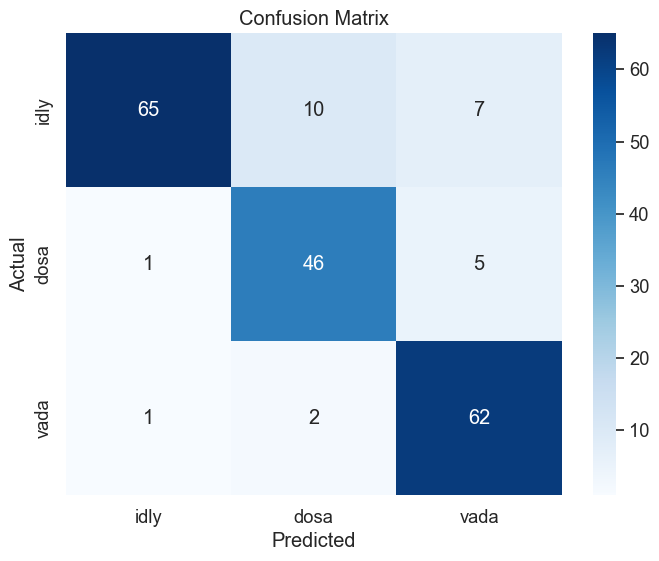

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader for the test set named test_loader
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
conf_matrix = confusion_matrix(all_labels, all_preds)

# Define class labels (replace with your actual class labels)
class_labels = ['idly', 'dosa', 'vada']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
